In [39]:
#!/usr/bin/env python
# coding: utf-8

# rdkit document
# http://rdkit.org/docs/source/rdkit.Chem.PandasTools.html

# SVGをdfに格納 matplotlibの描画確認 https://future-chem.com/rdkit-2ddraw-svg/#toc9


### DLしたcsvをクレンジング

In [285]:
import pandas as pd
import platform
print('python version: ' + platform.python_version())
print(f'rdkit version: {rdBase.rdkitVersion}')
# %%
# ChEMBLからDLしたファイルの読み込み
df = pd.read_csv('./csv/2022TYK2.csv',sep=';',)

# None(string)を0に変換
df = df.replace('None', '0')

# datatypeをfloatに変更
df['Molecular Weight'] = df['Molecular Weight'].astype(float)
df['pChEMBL Value'] = df['pChEMBL Value'].astype(float)
df['AlogP'] = df['AlogP'].astype(float)
df['Ligand Efficiency LLE'] = df['Ligand Efficiency LLE'].astype(float)
df['Document Year'] = df['Document Year'].fillna('2025').astype(int) #
df['#RO5 Violations'] = df['#RO5 Violations'].astype(int)
df['Molecule Max Phase'] = df['Molecule Max Phase'].astype(str)

# SmilesカラムのNanを空に変換
df['Smiles'] = df['Smiles'].fillna('')

# descriptorの追加
df['TPSA'] = df['Smiles'].apply(lambda x : Descriptors.TPSA(Chem.MolFromSmiles(x)))
df['Ct HA'] = df['Smiles'].apply(lambda x : Descriptors.HeavyAtomCount(Chem.MolFromSmiles(x)))
df['Ct F'] = df['Smiles'].apply(lambda x : x.count('F'))
df['HBD'] = df['Smiles'].apply(lambda x : Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
df['HBA'] = df['Smiles'].apply(lambda x : Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))
df['Ct RB'] = df['Smiles'].apply(lambda x : Descriptors.NumRotatableBonds(Chem.MolFromSmiles(x)))
df['Ct Ar'] = df['Smiles'].apply(lambda x : Descriptors.NumAromaticRings(Chem.MolFromSmiles(x)))
df['Fsp3'] = df['Smiles'].apply(lambda x : Descriptors.FractionCSP3(Chem.MolFromSmiles(x)))

# 文献数
print("the number of Document ChEMBL ID is " + str(len(df['Document ChEMBL ID'].unique())))

#欠損値の数をカウント https://note.nkmk.me/python-pandas-nan-judge-count/
# print('the number of missing value is ' + str(df.isnull().sum()))

# カラムをfiltering
# df = df.filter(items=['Molecule Name', 'Molecule ChEMBL ID', 'Smiles', 'Document ChEMBL ID'])
# df.head()

# %%
# Smiles ColumnからDataFrameに構造を描画
# https://www.macinchem.org/reviews/molsimilar/SimilarMyMolecules.html 
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors, Descriptors3D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools, rdRGroupDecomposition
from rdkit.Chem import Draw
from rdkit import DataStructs

# %%
PandasTools.AddMoleculeColumnToFrame(df,'Smiles','Molecule_Image',includeFingerprints=True)

# # Murcko Scaffoldの追加
PandasTools.AddMurckoToFrame(df, molCol='Molecule_Image', MurckoCol='Murcko_SMILES')
PandasTools.AddMurckoToFrame(df, molCol='Molecule_Image', MurckoCol='Murcko_generic_SMILES', Generic=True)
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_Mol', smilesCol='Murcko_SMILES')
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_generic_Mol', smilesCol='Murcko_generic_SMILES')
# PandasTools.FrameToGridImage(df[:8], column='Murcko_generic_Mol', legendsCol=None, molsPerRow=4)

# 骨格数情報 SMILESじゃないとなぜか反映されない
print("the number of Murcko generic scaffold is " + str(len(df['Murcko_generic_SMILES'].unique())))
print("the number of Murcko scaffold is " + str(len(df['Murcko_SMILES'].unique())))



python version: 3.10.6
rdkit version: 2022.03.5
the number of Document ChEMBL ID is 134
the number of Murcko generic scaffold is 419
the number of Murcko scaffold is 651


In [178]:
dfd = df.groupby(['Document Year'])['Document ChEMBL ID'].describe()
dfm = df.groupby(['Document Year'])['Murcko_generic_SMILES'].describe()
dfg = df.groupby(['Document ChEMBL ID'])['Murcko_generic_SMILES'].describe()

### Count of Documents and Scaffold by Year

In [179]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=dfd.index, y=dfd['unique'], name='Document count'))
fig.add_trace(go.Bar(x=dfm.index, y=dfm['unique'], name='Scaffold count'))

fig.update_layout(
    title='Murcko generic scaffold v.s. Year',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    barmode='group',
)
fig.show()

### pChEMBL Value box by Year

In [133]:
import plotly.express as px
fig = px.box(
    df,
    x='Document Year',
    y='pChEMBL Value',
    points='all',
)
fig.update_layout(
    title='pChEMBL Value v.s. Year',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 
fig.show()

### Filtering off by Molecule Name

In [209]:
import plotly.express as px
fig = px.scatter(
    df[df['Molecule Name'].notna()],
    x='Molecular Weight',
    y='pChEMBL Value',
    color='Molecule Max Phase',
    # color='Document ChEMBL ID',
    # color='Murcko_generic_SMILES',
    # size='AlogP',
    hover_name='Molecule Name',
    hover_data=['Document ChEMBL ID', df[df['Molecule Name'].notna()].index],
    opacity=0.5
)
fig.update_layout(
    title='pChEMBL Value v.s. MW',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 
fig.show()


### Summary Table of Specific Molecule

,Molecule Name,Molecule ChEMBL ID,Molecule_Image,Molecular Weight,pChEMBL Value,AlogP,Ligand Efficiency LLE,#RO5 Violations,Assay Description,Document ChEMBL ID
1326,DEUCRAVACITINIB,CHEMBL4435170,,425.47,10.7,1.73,8.97,0,Inhibition of TYK2 in human Jurkat cells asses...,CHEMBL4330088

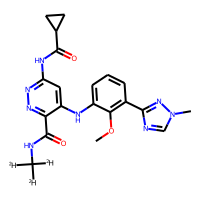

In [219]:
MolID = input('index?')
df[int(MolID):int(MolID)+1].filter(items=['Molecule Name', 
    'Molecule ChEMBL ID',
    'Molecule_Image',
    'Molecular Weight',
    'pChEMBL Value',
    'AlogP',
    'Ligand Efficiency LLE',
    '#RO5 Violations',
    'Assay Description',
    'Document ChEMBL ID'
])

### matplotlib

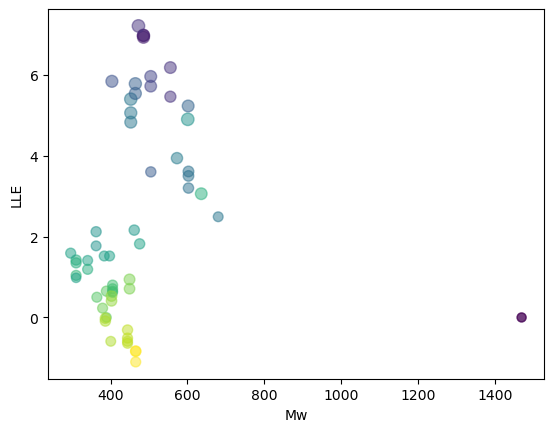

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# Document ChEMBL IDでfiltering
# ddf = df[df['Document ChEMBL ID']=='CHEMBL4622984'].dropna(subset=['Ligand Efficiency LLE', 'Molecular Weight', 'pChEMBL Value'])

# %%
fig, ax = plt.subplots()
# ax.set_xticks([400, 600, 800])
ax.scatter(x=df['Molecular Weight'], 
            y=df['Ligand Efficiency LLE'].replace('','0'), 
            alpha=0.5,
            s=df['pChEMBL Value'] *10,
            c=df['AlogP']
            )
ax.set_xlabel("Mw")
ax.set_ylabel("LLE")
# ax.set_xlim([400,800])
plt.show()


### Plotly.go scatter

In [180]:
import plotly.graph_objects as go

data1 = go.Scatter(x=df['Molecular Weight'], 
                    y=df['pChEMBL Value'],
                    mode='markers',
                    # fill='Murcko_generic_SMILES'
                    )
go.Figure(data1)


### Plotly.px scatter

In [181]:
import plotly.express as px
fig = px.scatter(df,
    x='Molecular Weight',
    y='Ligand Efficiency LLE',
    color='Molecule Max Phase',
    # color='AlogP',
    # color='Document ChEMBL ID',
    # color='Murcko_generic_SMILES',
    # size='pChEMBL Value',
    hover_name='Molecule ChEMBL ID',
    hover_data=['Document ChEMBL ID', df.index],
    opacity=0.5
)
fig.update_layout(
    title='LLE v.s. MW',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
) 
fig.show()


### Plotly.3D scatter

In [50]:
import plotly.express as px
fig = px.scatter_3d(df,
                    x='Molecular Weight',
                    z='pChEMBL Value',
                    y='AlogP',
                    color='Document ChEMBL ID',
                    # color='Murcko_generic_SMILES',
                    # size='pChEMBL Value',
                    hover_name='Molecule ChEMBL ID',
                    hover_data=['Molecule ChEMBL ID',df.index],
                    opacity=0.5)
fig.update_layout(
    # showlegend=False, # Legendのon/off
    width=1200,
    height=1000
    ) 
fig.show()

### Plotly.violin

In [35]:
fig = px.violin(df,
                x='Document ChEMBL ID',
                y='Ligand Efficiency LLE',
                color='Document ChEMBL ID',
                box=True,
                points='all',
                hover_data=['Molecular Weight', 'AlogP', 'pChEMBL Value']
                )
fig.update_layout(
    title='pValue v.s. Document ChEMBL ID',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 

fig.show()

### Plotly.box

In [182]:
fig = px.box(df,
                y='Ligand Efficiency LLE',
                x='Document ChEMBL ID',
                color='Document ChEMBL ID',
                points='all',
                hover_data=['Molecular Weight', 'AlogP', 'pChEMBL Value', df.index]
                )
fig.update_layout(
    title='LLE v.s. Document ChEMBL ID',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 

fig.show()

### matplotlib.mouseover

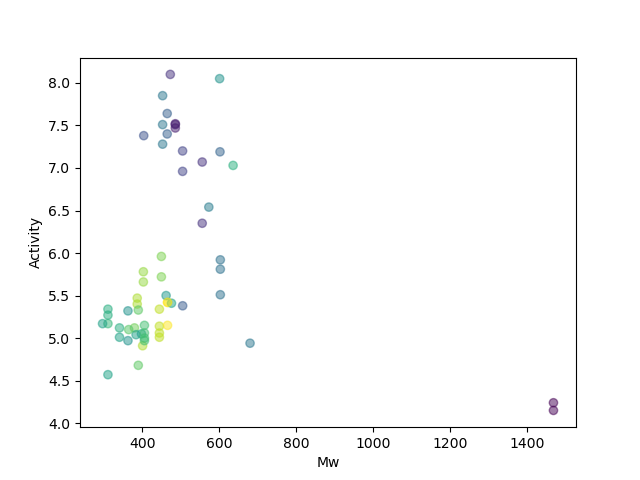

In [8]:
# https://choron81.hatenablog.com/entry/2022/11/30/000000
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

mols = [Chem.MolFromSmiles(Smile) for Smile in df["Smiles"]]
ims=[Draw.MolToImage(mol) for mol in mols]

# %%
fig, ax = plt.subplots()
imagebox = OffsetImage(ims[0], zoom=0.3)
imagebox.image.axes = ax

annot = AnnotationBbox(imagebox,
                       xy=(0,0),
                       xybox=(60,-60),
                       xycoords="data",
                       boxcoords="offset points",
                       pad=0.5,
                       arrowprops=dict( arrowstyle="->"))
annot.set_visible(False)
ax.add_artist(annot)
    
x = df["Molecular Weight"]#x軸は分子量。
y = df["pChEMBL Value"]#y軸は活性値。
colors = df["AlogP"]#色はAlogP。
sc = plt.scatter(x, y, c=colors, alpha=0.5)

def update_annot(ind):
    i = ind["ind"][0]
    pos = sc.get_offsets()[i]
    annot.xy = (pos[0], pos[1])
    imagebox.set_data(ims[i])

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

ax.set_xlabel("Mw")
ax.set_ylabel("Activity")
# plt.yscale('log')#y軸は対数軸にした。

# fig.colorbar(sc, ax=ax)#カラーバーを付けた。

plt.show()



### Drawing molecules

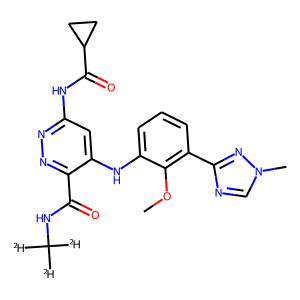

In [208]:
Cn = input('Molecule index?')
Draw.MolToImage(df['Molecule_Image'].iloc[int(Cn)])

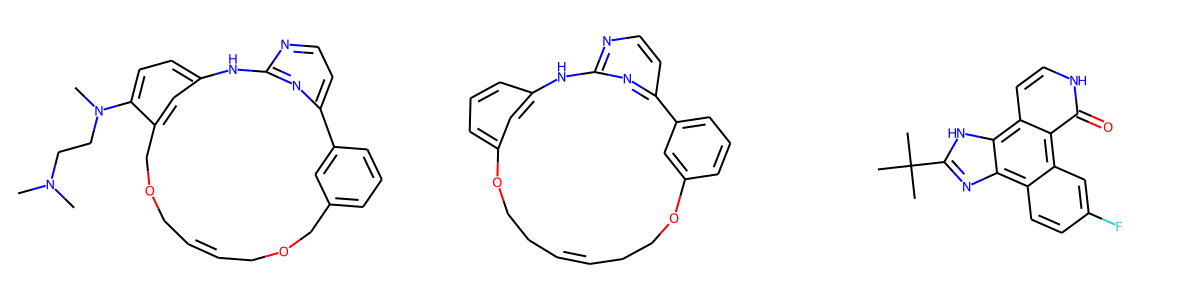

In [164]:
Draw.MolsToGridImage(df['Molecule_Image'].iloc[0:3],
                        molsPerRow=3,
                        subImgSize=(400,300)
                        )

### Filtering by Document ChEMBLE ID

In [183]:
# filtering with Document ChEMBLE ID CHEMBL2176955
DocID = input('Document ChEMBL ID?')
ddf = df[df['Document ChEMBL ID']==DocID]

### Viewing top 3 compounds

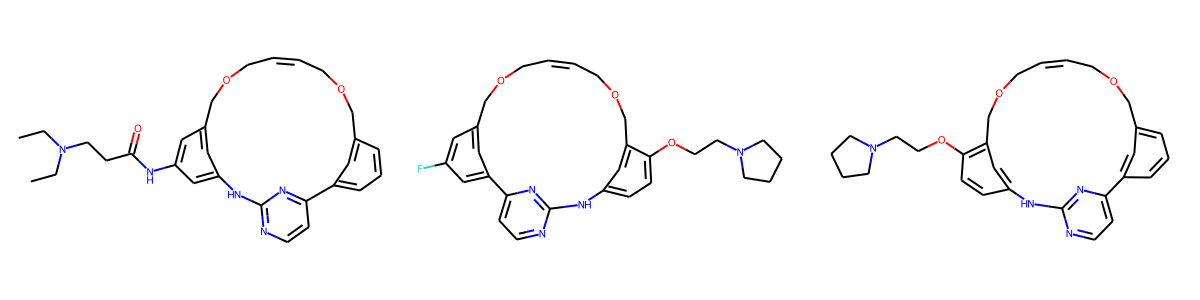

In [184]:
Draw.MolsToGridImage(ddf.sort_values('pChEMBL Value', ascending=False)['Molecule_Image'].iloc[0:3],
                        molsPerRow=3,
                        subImgSize=(400,300),
                        )

### show summary table

,Molecule Name,Molecule ChEMBL ID,Molecule_Image,pChEMBL Value,AlogP,#RO5 Violations,Assay Description,Document ChEMBL ID
0,NaN,CHEMBL2181327,,7.15,4.49,0,Inhibition of recombinant TYK2,CHEMBL2176955
1,NaN,CHEMBL2181315,,5.28,4.99,0,Inhibition of recombinant TYK2,CHEMBL2176955
16,NaN,CHEMBL2181322,,6.85,3.90,0,Inhibition of recombinant TYK2,CHEMBL2176955

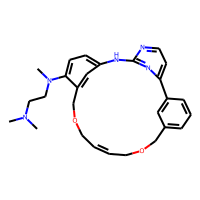
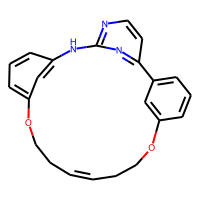
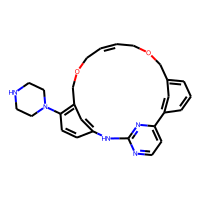

In [185]:
ddf.filter(items=['Molecule Name', 
    'Molecule ChEMBL ID',
    'Molecule_Image',
    'Moleculer Weight',
    'pChEMBL Value',
    'AlogP',
    'Ligand effieicncy LLE',
    '#RO5 Violations',
    'Assay Description',
    'Document ChEMBL ID'
]).head(3)


### Save summary csv

In [145]:
ddf.filter(items=['Molecule Name', 
                 'Molecule ChEMBL ID',
                 'Smiles',
                 'Moleculer Weight',
                 'pChEMBL Value',
                 'AlogP',
                 'Ligand effieicncy LLE',
                 '#RO5 Violations',
                 'Assay Description',
                 'Document ChEMBL ID'
                 ]).to_csv('test2.csv')


### Plotly.scatter

In [186]:
import plotly.express as px
fig = px.scatter(ddf,
                    x='Molecular Weight',
                    y='Ligand Efficiency LLE',
                    # color='AlogP',
                    color='Murcko_SMILES',
                    # color='Murcko_generic_SMILES',
                    # size='pChEMBL Value',
                    hover_name='Molecule ChEMBL ID',
                    hover_data=['Murcko_SMILES', ddf.index],
                    opacity=0.5
                )
fig.update_layout(
    title='LLE v.s. MW',
    # showlegend=False, # Legendのon/off
    width=1400,
    # height=700
    ) 
fig.show()


### Plotly.box

In [187]:
fig = px.box(ddf,
                x='Ligand Efficiency LLE',
                y='Murcko_SMILES',
                color='Murcko_SMILES',
                points='all',
                hover_data=['Molecular Weight', 'AlogP', 'pChEMBL Value', ddf.index]
                )
fig.update_layout(
    title='LLE v.s. Document ChEMBL ID',
    showlegend=False, # Legendのon/off
    width=1600,
    # height=800
    ) 

fig.show()

##### PMI plot

In [298]:
# 立体構造の追加
ddf['AddHs'] = ddf['Molecule_Image'].apply(lambda x : AllChem.AddHs(x))
ddf['3D'] = ddf['AddHs'].apply(lambda x : AllChem.EmbedMolecule(x, AllChem.ETKDGv3()))
ddf['3D'] = ddf['AddHs'].apply(lambda x : AllChem.RemoveHs(x))
ddf['NPR1'] = ddf['AddHs'].apply(lambda x : Descriptors3D.NPR1(x))
ddf['NPR2'] = ddf['AddHs'].apply(lambda x : Descriptors3D.NPR2(x))
ddf['Molecule Max Phase'] = ddf['Molecule Max Phase'].astype(str)

import plotly.express as px
fig = px.scatter(ddf,
    x='NPR1',
    y='NPR2',
    color='Molecule Max Phase',
    # color='AlogP',
    # color='Document ChEMBL ID',
    # color='Murcko_generic_SMILES',
    # size='pChEMBL Value',
    # hover_name='Molecule ChEMBL ID',
    # hover_data=['Document ChEMBL ID', df.index],
    opacity=0.5
)
fig.update_layout(
    title='PMI plot',
    # showlegend=False, # Legendのon/off
    width=700,
    # height=700,
    xaxis=dict(range= (0,1)),
    yaxis=dict(range= (0.5,1))
) 
fig.show()


##### add pdb id
##### pymol